# Falkner–Skan — Numerical Solution

This notebook runs all four parts of the deliverables.

1. Node tables for $(\eta, f, f', f'')$ at nodes 1, 5, 10, 20, …, $N$ for each $\beta$.

2. Plots of $f'(\eta)$ and $f''(\eta)$ for each $\beta$.

3. For each $\beta$, report:**

   a) The converged value $s = f''(0)$.

    b) Displacement thickness

    $$
    \delta^{*}=\int_{0}^{\eta_{\text{large}}}\!\left(1-f'(\eta)\right)\,d\eta
    \approx \left(\eta-f(\eta)\right)\Big|_{0}^{\eta_{\text{large}}}
    $$

    c) Momentum thickness

    $$
    \theta=\int_{0}^{\eta_{\text{large}}}\! f'(\eta)\left(1-f'(\eta)\right)\,d\eta
    = \frac{f''(0)-\beta\,\eta^{*}}{1+\beta}
    $$
    where $\eta^{*}$ is defined consistently with your derivation.


4. Flow field visuals (streamlines + representative $u/U_e$ vs $y$) for $\beta = -0.2,\, 0.0,\, 1.0$.

    The stream function $\psi(x, y)$ is related to the similarity solution $f(\eta)$ by:
    $$
    \psi(x, y) = \sqrt{\frac{2\nu x U}{m+1}} f(\eta)
    $$

    The similarity variable $\eta$ is defined as:
    $$
    \eta = y\sqrt{\frac{m+1}{2}} \sqrt{\frac{U}{\nu x}}
    $$

    where the external velocity is given by $U = Cx^m$ and the pressure gradient parameter is related to $m$ by $\beta = \frac{2m}{m+1}$.



### Setup

In [1]:
# --- Setup: imports + single "results" folder (no nested run dir) ---
from pathlib import Path
from datetime import datetime  # keep if you want to timestamp filenames
import csv
from typing import Callable, Tuple, Dict, Tuple as Tup
import numpy as np
import matplotlib.pyplot as plt

# One top-level directory only
BASE_OUT = Path("results")
BASE_OUT.mkdir(parents=True, exist_ok=True)

# Helpers for output folders
def make_outdir(name: str) -> Path:
    p = BASE_OUT / name
    p.mkdir(parents=True, exist_ok=True)
    return p

def method_dir(root: Path, method: str) -> Path:
    d = root / method
    d.mkdir(parents=True, exist_ok=True)
    return d

# Optional timestamp you can append to filenames if you want uniqueness
STAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

print("Saving all outputs under:", BASE_OUT.resolve())


Saving all outputs under: E:\Fluid_Mechanics\MidTerm_Project\results


### Core Functions (Falkner–Skan Solver)

In [2]:
# --- Core Falkner–Skan functions (self-contained) ---
def fs_rhs(beta: float) -> Callable[[float, np.ndarray], np.ndarray]:
    """RHS for the primary first-order system:
        f' = g
        g' = h
        h' = -f h - β (1 - g^2)
    """
    def F(_eta: float, y: np.ndarray) -> np.ndarray:
        f, g, h = y
        return np.array([g, h, -f*h - beta*(1.0 - g*g)])
    return F

def rk4_solve(F: Callable[[float, np.ndarray], np.ndarray],
              tspan: Tuple[float, float],
              y0: np.ndarray, h: float) -> Tuple[np.ndarray, np.ndarray]:
    """Vector RK4 with fixed step."""
    t0, tf = tspan
    n = int(np.round((tf - t0)/h))
    ts = np.linspace(t0, t0 + n*h, n+1)
    ys = np.zeros((n+1, len(y0)))
    ys[0] = y0
    for i in range(n):
        t, y = ts[i], ys[i]
        k1 = F(t, y)
        k2 = F(t + 0.5*h, y + 0.5*h*k1)
        k3 = F(t + 0.5*h, y + 0.5*h*k2)
        k4 = F(t + h,      y + h*k3)
        ys[i+1] = y + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return ts, ys

def integrate_primary(beta: float, s: float, h: float, eta_max: float):
    """Integrate with f(0)=0, g(0)=0, h(0)=s (s = f''(0)). Returns eta, Y=[f,g,h]."""
    F = fs_rhs(beta)
    y0 = np.array([0.0, 0.0, s])
    eta, Y = rk4_solve(F, (0.0, eta_max), y0, h)
    return eta, Y

def secant_shoot(F: Callable[[float, np.ndarray], np.ndarray],
                 s0: float, s1: float, tspan: Tuple[float, float], h: float,
                 tol: float = 1e-6, maxit: int = 50):
    """Secant method on residual φ(s) = g(η_max; s) - 1. Returns (s*, iterations)."""
    def residual(s: float) -> float:
        y0 = np.array([0.0, 0.0, s])
        _, Y = rk4_solve(F, tspan, y0, h)
        return Y[-1, 1] - 1.0

    r0 = residual(s0); r1 = residual(s1)
    it = 0
    while it < maxit and abs(s1 - s0) > tol:
        if r1 == r0:
            break
        s2 = s1 - r1 * (s1 - s0) / (r1 - r0)
        s0, s1 = s1, s2
        r0, r1 = r1, residual(s1)
        it += 1
        if abs(r1) < tol:
            break
    return s1, it

def shoot_secant(beta: float, s0: float, s1: float, h: float, eta_max: float,
                 tol: float = 1e-6, maxit: int = 50):
    """Wrapper to run the secant shooting method for a given beta."""
    F = fs_rhs(beta)
    return secant_shoot(F, s0, s1, (0.0, eta_max), h, tol=tol, maxit=maxit)

def shoot_newton(beta: float, s_init: float, h: float, eta_max: float,
                 tol: float = 1e-6, maxit: int = 25):
    """Newton shooting using sensitivities; returns (s*, iterations, eta, Y)."""
    def rhs_aug(beta: float):
        """Augmented system for sensitivity w.r.t. s:
           y = [f, g, h, F, G, H] with:
             Primary:   f' = g,  g' = h,  h' = -f h - β(1 - g^2)
             Auxiliary: F' = G,  G' = H,  H' = -f H - h F + 2β g G
        """
        def Faug(_eta: float, y: np.ndarray) -> np.ndarray:
            f, g, h_, F, G, H = y
            # Primary system
            df, dg, dh = g, h_, -f*h_ - beta*(1.0 - g*g)
            # Auxiliary system
            dF, dG, dH = G, H, -f*H - h_*F + 2.0*beta*g*G
            return np.array([df, dg, dh, dF, dG, dH])
        return Faug

    def rk4_aug(F, tspan, y0, step):
        """RK4 for the augmented system."""
        t0, tf = tspan
        n = int(np.round((tf - t0)/step))
        ts = np.linspace(t0, t0 + n*step, n+1)
        ys = np.zeros((n+1, len(y0)))
        ys[0] = y0
        for i in range(n):
            t, y = ts[i], ys[i]
            k1 = F(t, y)
            k2 = F(t + 0.5*step, y + 0.5*step*k1)
            k3 = F(t + 0.5*step, y + 0.5*step*k2)
            k4 = F(t + step,      y + step*k3)
            ys[i+1] = y + (step/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        return ts, ys

    F = rhs_aug(beta)
    s = float(s_init)
    it = 0
    while it < maxit:
        # Initial conditions: f, g, h, F, G, H. (H(0)=1 gives d h(0)/ds = 1)
        y0 = np.array([0.0, 0.0, s, 0.0, 0.0, 1.0])
        _, YY = rk4_aug(F, (0.0, eta_max), y0, h)
        g_end, G_end = YY[-1, 1], YY[-1, 4]
        phi = g_end - 1.0
        if abs(G_end) < 1e-14:
            break
        s_new = s - phi / G_end
        if abs(s_new - s) < tol:
            s = s_new
            break
        s = s_new
        it += 1

    eta, Y = integrate_primary(beta, s, h, eta_max)
    return s, it, eta, Y

def thicknesses(eta: np.ndarray, f: np.ndarray, fp: np.ndarray,
                beta: float, s: float):
    """Calculates displacement (δ*), momentum (θ) and η* (when β≠0)."""
    dstar_trapz = np.trapz(1.0 - fp, eta)
    dstar_endpt = eta[-1] - f[-1]
    theta = np.trapz(fp*(1.0 - fp), eta)
    eta_star = None if abs(beta) < 1e-14 else (s - (1.0 + beta)*theta)/beta
    return dstar_trapz, dstar_endpt, theta, eta_star

def nodes_subset(eta: np.ndarray, Y: np.ndarray):
    """Extract nodes 1, 5, 10, 20, N (1-based in output)."""
    idx = [0, 4, 9, 19]
    idx = [i for i in idx if i < len(eta)]
    if (len(eta)-1) not in idx:
        idx.append(len(eta)-1)
    return [(k+1, eta[k], Y[k,0], Y[k,1], Y[k,2]) for k in idx]

def beta_to_m(beta: float) -> float:
    """Wedge-flow parameter: m = β / (2 - β)."""
    return beta/(2.0 - beta)

class FSParams:
    """Container for step size, η_max, and shooting initial guesses."""
    def __init__(self, h, eta_max, secant_guess, newton_guess):
        self.h = h
        self.eta_max = eta_max
        self.secant_guess = secant_guess
        self.newton_guess = newton_guess

def choose_params_for_beta(beta: float) -> FSParams:
    """Sets step size, η_max, and initial guesses based on β."""
    h = 0.01
    if beta <= -0.2:
        eta_max = 18.0
    elif beta <= -0.1:
        eta_max = 14.0
    elif beta == 0.0:
        eta_max = 10.0
    elif beta <= 0.5:
        eta_max = 8.0
    else:
        eta_max = 7.0

    secant_guesses = {
        -0.2: (0.05, 0.15),
        -0.1: (0.20, 0.35),
        0.0:  (0.35, 0.65),
        0.5:  (0.80, 1.10),
        1.0:  (1.10, 1.40),
    }
    newton_guess = {
        -0.2: 0.10,
        -0.1: 0.28,
        0.0:  0.50,
        0.5:  0.95,
        1.0:  1.25,
    }
    return FSParams(h, eta_max, secant_guesses.get(beta, (0.30, 0.50)),
                    newton_guess.get(beta, 0.50))

# Helper to solve one beta with chosen method
def solve_beta(beta: float, method: str, P: FSParams, tol: float = 1e-6):
    method = method.lower().strip()
    if method == "newton":
        s_star, iters, eta, Y = shoot_newton(beta, P.newton_guess, P.h, P.eta_max, tol=tol)
    elif method == "secant":
        s_star, iters = shoot_secant(beta, *P.secant_guess, P.h, P.eta_max, tol=tol)
        eta, Y = integrate_primary(beta, s_star, P.h, P.eta_max)
    else:
        raise ValueError("method must be 'secant' or 'newton'")
    return s_star, iters, eta, Y


### Deliverable 1: Tables (nodes 1,5,10,20,N) for both methods

In [3]:
# Deliverable 1 — Tables for required betas (Secant **and** Newton)

betas   = [-0.2, -0.1, 0.0, 0.5, 1.0]
METHODS = ["secant", "newton"]

part1_dir = make_outdir("part1_table")

# cache solutions for later blocks
SOLN: Dict[Tup[str, float], Dict[str, np.ndarray]] = {}
FAIL = []

# Solve with both methods, all betas
for method in METHODS:
    for beta in betas:
        P = choose_params_for_beta(beta)
        try:
            s_star, iters, eta, Y = solve_beta(beta, method, P)
            SOLN[(method, beta)] = {"s": s_star, "iters": iters, "eta": eta, "Y": Y}
        except Exception as e:
            print(f"[{method}] β={beta}: solver did not converge ({e}).")
            FAIL.append((method, beta, str(e)))

# Emit tables + save per-method files
for method in METHODS:
    mdir = method_dir(part1_dir, method)
    for beta in betas:
        key = (method, beta)
        if key not in SOLN:
            continue
        s_star = SOLN[key]["s"]
        iters  = SOLN[key]["iters"]
        eta    = SOLN[key]["eta"]
        Y      = SOLN[key]["Y"]

        print(f"\n=== [{method}] β = {beta:+.1f} | s=f''(0)={s_star:.8f} | iters={iters} ===")
        header = "{:>6} {:>8} {:>13} {:>13} {:>13}".format("Node", "η", "f", "f'", "f''")
        print(header)
        rows = nodes_subset(eta, Y)
        for node, et, f, fp, fpp in rows:
            print(f"{node:6d} {et:8.3f} {f:13.8f} {fp:13.8f} {fpp:13.8f}")

        # Save CSV and full profiles
        csv_path = mdir / f"table_{method}_beta_{beta:+.1f}.csv"
        with open(csv_path, "w", newline="") as fobj:
            w = csv.writer(fobj)
            w.writerow(["Node", "eta", "f", "f_prime", "f_dprime"])
            for node, et, f, fp, fpp in rows:
                w.writerow([node, et, f, fp, fpp])

        np.savez(mdir / f"profiles_{method}_beta_{beta:+.1f}.npz",
                 eta=eta, f=Y[:,0], fp=Y[:,1], fpp=Y[:,2], s=s_star, iters=iters)
        print("Saved", csv_path)

if FAIL:
    print("\nWarnings: some cases failed and were skipped:", FAIL)



=== [secant] β = -0.2 | s=f''(0)=0.00781852 | iters=50 ===
  Node        η             f            f'           f''
     1    0.000    0.00000000    0.00000000    0.00781852
     5    0.040    0.00000839    0.00047274    0.01581851
    10    0.090    0.00005596    0.00151367    0.02581847
    20    0.190    0.00036976    0.00509548    0.04581755
  1801   18.000   15.70649911    1.00095683   -0.00002452
Saved results\part1_table\secant\table_secant_beta_-0.2.csv

=== [secant] β = -0.1 | s=f''(0)=0.31926976 | iters=3 ===
  Node        η             f            f'           f''
     1    0.000    0.00000000    0.00000000    0.31926976
     5    0.040    0.00025648    0.01285078    0.32326844
    10    0.090    0.00130519    0.02913894    0.32825450
    20    0.190    0.00587687    0.06245931    0.33812189
  1401   14.000   12.55730322    1.00000000   -0.00000000
Saved results\part1_table\secant\table_secant_beta_-0.1.csv

=== [secant] β = +0.0 | s=f''(0)=0.46959999 | iters=4 ===
  Node

### Deliverable 2 - Plots of $f'(\eta)$ and $f''(\eta)$

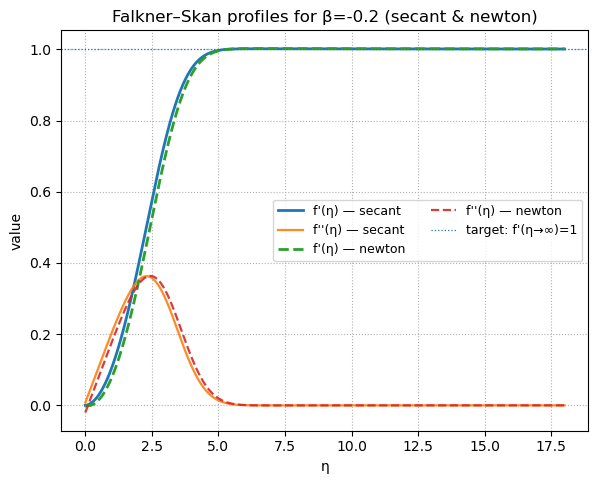

Saved results\part2_plots\both_methods_same_plot\profiles_both_methods_beta_-0.2.png


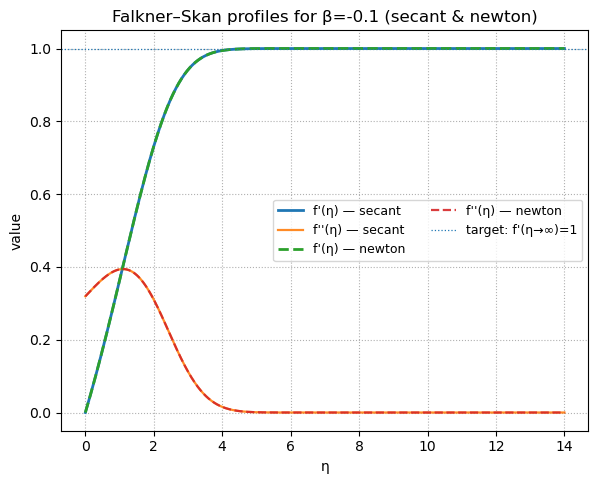

Saved results\part2_plots\both_methods_same_plot\profiles_both_methods_beta_-0.1.png


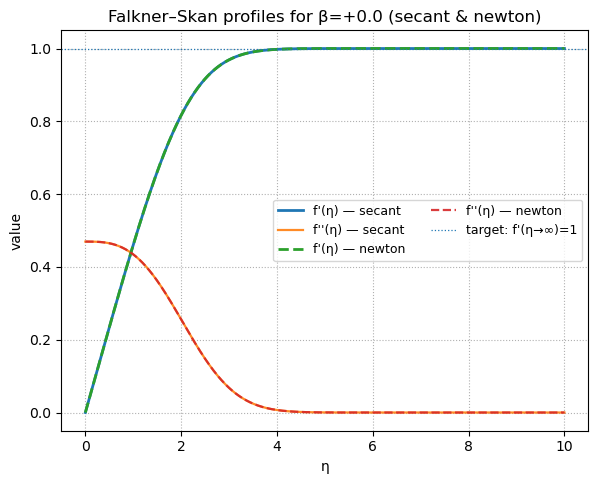

Saved results\part2_plots\both_methods_same_plot\profiles_both_methods_beta_+0.0.png


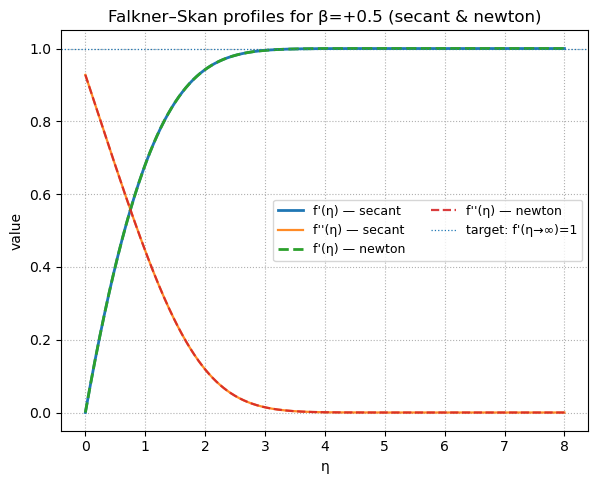

Saved results\part2_plots\both_methods_same_plot\profiles_both_methods_beta_+0.5.png


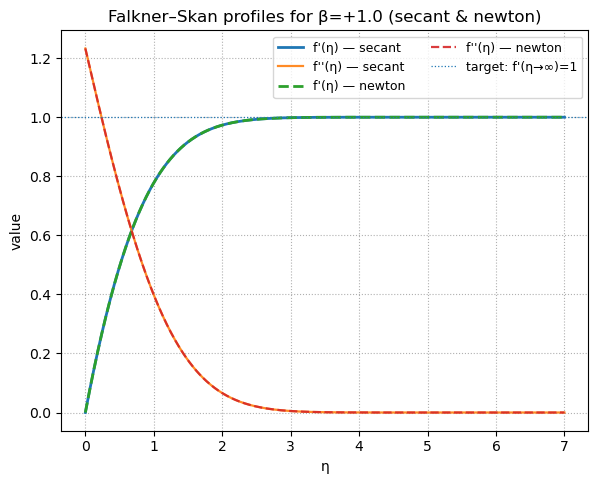

Saved results\part2_plots\both_methods_same_plot\profiles_both_methods_beta_+1.0.png


In [4]:
# %% [markdown]
# Deliverable 2 — Plots of f'(η) and f''(η) with **both methods on the same figure** (per β)

# %% [code]
part2_dir = make_outdir("part2_plots")
both_dir  = method_dir(part2_dir, "both_methods_same_plot")

for beta in betas:
    have_secant = ("secant", beta) in SOLN
    have_newton = ("newton", beta) in SOLN
    if not (have_secant or have_newton):
        print(f"β={beta}: not plotted (no solution cached).")
        continue

    fig, ax = plt.subplots(figsize=(6.8, 5.2))

    # --- Secant curves ---
    if have_secant:
        eta_s = SOLN[("secant", beta)]["eta"]
        Y_s   = SOLN[("secant", beta)]["Y"]
        ax.plot(eta_s, Y_s[:, 1], "-",  lw=2.0, label="f'(η) — secant")
        ax.plot(eta_s, Y_s[:, 2], "-",  lw=1.6, label="f''(η) — secant", alpha=0.9)

    # --- Newton curves ---
    if have_newton:
        eta_n = SOLN[("newton", beta)]["eta"]
        Y_n   = SOLN[("newton", beta)]["Y"]
        ax.plot(eta_n, Y_n[:, 1], "--", lw=2.0, label="f'(η) — newton")
        ax.plot(eta_n, Y_n[:, 2], "--", lw=1.6, label="f''(η) — newton", alpha=0.9)

    # Target line for f'(η→∞)=1
    ax.axhline(1.0, ls=":", lw=0.9, label="target: f'(η→∞)=1")

    ax.set_xlabel("η")
    ax.set_ylabel("value")
    ax.set_title(f"Falkner–Skan profiles for β={beta:+.1f} (secant & newton)")
    ax.grid(ls=":")
    ax.legend(loc="best", ncol=2, fontsize=9)

    out = both_dir / f"profiles_both_methods_beta_{beta:+.1f}.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved", out)


### Deliverable 3: Thickness metrics & summary tables for both methods

In [5]:
# Deliverable 3 — Thickness (δ*, θ, η*) and Summary Tables (both methods)
# First short print table removed; only the full detailed table is printed.

part3_dir = make_outdir("part3_thickness")

# Full summary CSV with clear, explicit headers (both methods)
summary_csv = part3_dir / "thickness_summary_all_methods.csv"
with open(summary_csv, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow([
        "β",
        "method",
        "Converged s = f''(0)",
        "Displacement thickness δ* (trapz)",
        "Displacement thickness δ* (end-point)",
        "Momentum thickness θ",
        "η* (from θ = (s - βη*)/(1+β))",
        "iterations"
    ])

pretty_rows = []   # (beta, method, s*)
detail_rows = []   # (beta, method, s*, d*, d*_endpt, θ, η*, iters)

for method in METHODS:
    for beta in betas:
        key = (method, beta)
        if key not in SOLN:
            # keep this warning so you know if something failed
            print(f"[{method}] β={beta}: no result for thickness.")
            continue

        s_star = SOLN[key]["s"]
        iters  = SOLN[key]["iters"]
        eta    = SOLN[key]["eta"]
        Y      = SOLN[key]["Y"]

        f, fp = Y[:,0], Y[:,1]
        dstar_trapz, dstar_endpt, theta, eta_star = thicknesses(eta, f, fp, beta, s_star)

        with open(summary_csv, "a", newline="", encoding="utf-8") as fobj:
            w = csv.writer(fobj)
            w.writerow([
                beta, method, s_star, dstar_trapz, dstar_endpt, theta,
                "" if eta_star is None else eta_star, iters
            ])

        pretty_rows.append((beta, method, s_star))
        detail_rows.append((beta, method, s_star, dstar_trapz, dstar_endpt, theta, eta_star, iters))

# === Console output (only the detailed table) ===
print("\nFull thickness summary (both methods):")
hdr_labels = [
    "β", "method", "Converged s = f''(0)",
    "δ* (trapz)", "δ* (end-point)", "θ (momentum)",
    "η* (identity)", "iters"
]
hdr_fmt = "{:>6} {:>10} {:>24} {:>14} {:>18} {:>14} {:>14} {:>7}"
print(hdr_fmt.format(*hdr_labels))

row_fmt = "{:6.1f} {:>10} {:24.6f} {:14.6f} {:18.6f} {:14.6f} {:>14} {:7d}"
for beta, method, s_star, d1, d2, th, eta_star, iters in detail_rows:
    eta_star_disp = "" if eta_star is None else f"{eta_star:.6f}"
    print(row_fmt.format(beta, method, s_star, d1, d2, th, eta_star_disp, iters))

print("\nSaved", summary_csv)

# Also save a separate two-column CSV with just β and Converged s (per method)
for method in METHODS:
    s_table_csv = part3_dir / f"converged_s_table_{method}.csv"
    with open(s_table_csv, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["β", "Converged s = f''(0)"])
        for beta, mthd, s in pretty_rows:
            if mthd == method:
                w.writerow([beta, s])
    print("Saved", s_table_csv)



Full thickness summary (both methods):
     β     method     Converged s = f''(0)     δ* (trapz)     δ* (end-point)   θ (momentum)  η* (identity)   iters
  -0.2     secant                 0.007819       2.293501           2.293501       0.564393       2.218481      50
  -0.1     secant                 0.319270       1.442699           1.442697       0.515041       1.442673       3
   0.0     secant                 0.469600       1.216785           1.216781       0.469596                      4
   0.5     secant                 0.927680       0.804556           0.804549       0.350263       0.804572       4
   1.0     secant                 1.232588       0.647909           0.647899       0.292332       0.647924       9
  -0.2     newton                -0.020168       2.427528           2.427528       0.555354       2.322258      25
  -0.1     newton                 0.319270       1.442699           1.442697       0.515041       1.442673       2
   0.0     newton                 0.4696

### Deliverable 4: Flow field streamlines

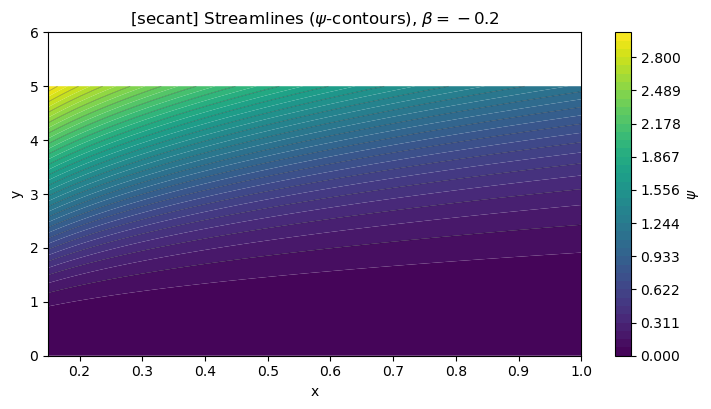

Saved results\part4_flowfield\secant\psi_streamlines_secant_beta_m0p2.png


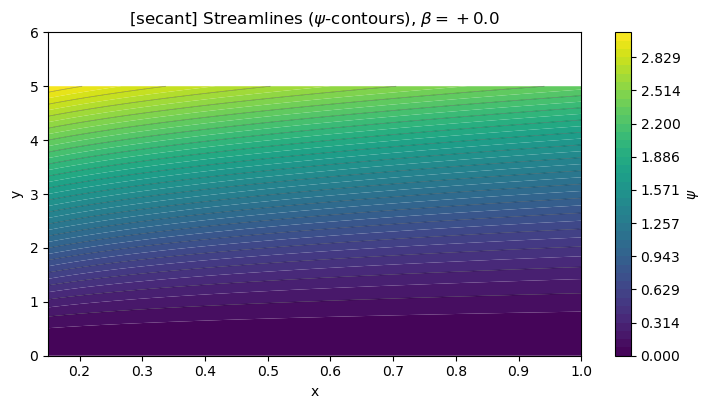

Saved results\part4_flowfield\secant\psi_streamlines_secant_beta_0p0.png


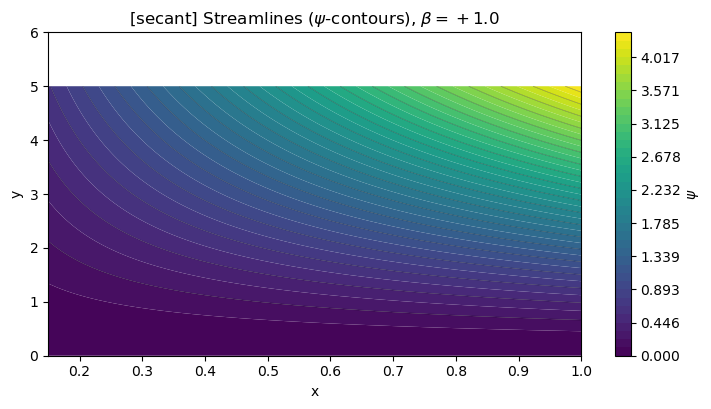

Saved results\part4_flowfield\secant\psi_streamlines_secant_beta_1p0.png


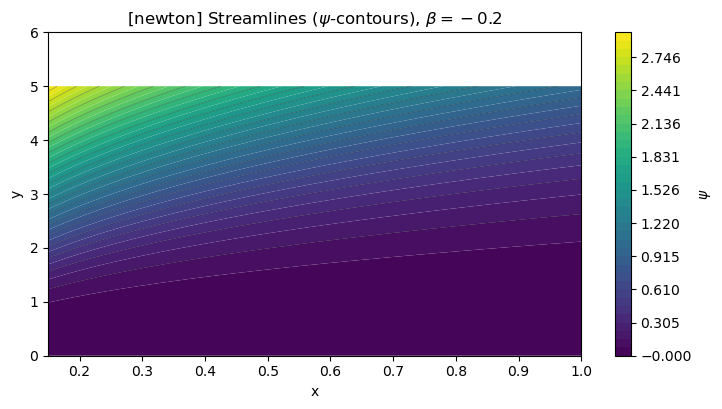

Saved results\part4_flowfield\newton\psi_streamlines_newton_beta_m0p2.png


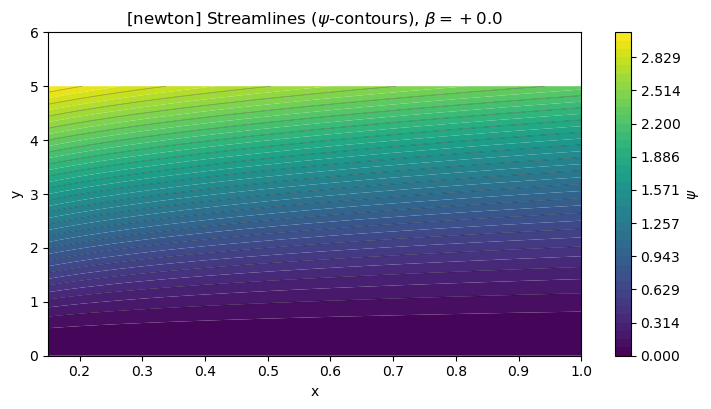

Saved results\part4_flowfield\newton\psi_streamlines_newton_beta_0p0.png


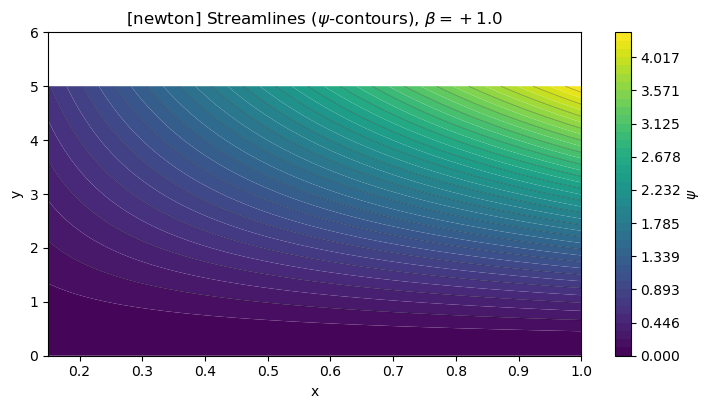

Saved results\part4_flowfield\newton\psi_streamlines_newton_beta_1p0.png


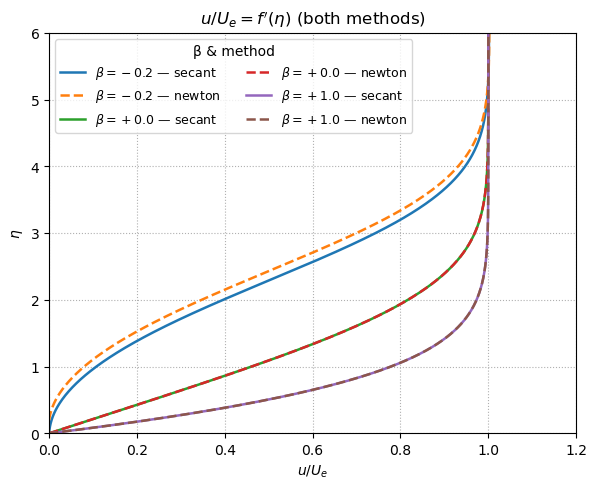

Saved results\part4_flowfield\both_methods_same_plot\u_profiles_similarity_curves_both_methods.png


In [7]:
# %% [markdown]
# Deliverable 4 — Flow field (streamlines) + u-velocity profiles in η

import numpy as np
import matplotlib.pyplot as plt

part4_dir = make_outdir("part4_flowfield")

def scaled_fields(beta, eta, f, fp, nx=120, ny=160):
    """
    Build similarity-scaled fields on an (x, y) grid.
    Returns X, Y, ETA, psi, u_over_Ue, where:
      psi = x^{(m+1)/2} * f(ETA)
      u_over_Ue = f'(ETA)
      ETA = y / δ(x), δ(x) = sqrt(2/(m+1)) * x^{(1-m)/2}
    """
    m = beta_to_m(beta)
    x = np.linspace(0.15, 1.00, nx)  # avoid x=0 singularity
    y = np.linspace(0.0, 5.0, ny)
    X, Yy = np.meshgrid(x, y)
    delta = np.sqrt(2.0/(m+1.0)) * X**((1.0 - m)/2.0)
    ETA = Yy / delta

    # Interpolate f, f' onto the ETA grid (clip for safety)
    ETAc = np.clip(ETA, eta[0], eta[-1])
    f_on  = np.interp(ETAc.ravel(), eta, f).reshape(ETA.shape)
    fp_on = np.interp(ETAc.ravel(), eta, fp).reshape(ETA.shape)

    psi = X**((m+1.0)/2.0) * f_on      # streamfunction (scaled)
    u_over_Ue = fp_on                  # u / U_e(x)
    return X, Yy, ETA, psi, u_over_Ue

# Betas to visualize
viz_betas = [-0.2, 0.0, 1.0]

# --- Build results for BOTH methods, then reuse for all plots ---
results_by_method = {m: {} for m in METHODS}
failed = []

for method in METHODS:
    for beta in viz_betas:
        key = (method, beta)
        if key not in SOLN:
            print(f"[{method}] β={beta}: skip viz (no solution cached).")
            failed.append((method, beta))
            continue
        eta = SOLN[key]["eta"]; Y = SOLN[key]["Y"]
        f, fp = Y[:,0], Y[:,1]
        X, Yy, ETA, psi, uUe = scaled_fields(beta, eta, f, fp)
        results_by_method[method][beta] = {
            "X": X, "Y": Yy, "ETA": ETA, "psi": psi, "uUe": uUe,
            "eta": eta, "fp": fp
        }

# Union of betas that actually succeeded in either method
betas_plotted = sorted({b for m in METHODS for b in results_by_method[m].keys()}) or viz_betas

# ---------- (A) Streamlines per method — colorful ψ-contours ----------
eta_max_display = 6.0
n_levels    = 40            # more => smoother color bands
cmap_name   = "viridis"     # change palette if you like
line_color  = "k"
line_width  = 0.5
line_alpha  = 0.35

for method in METHODS:
    mdir = method_dir(part4_dir, method)
    for beta in betas_plotted:
        if beta not in results_by_method[method]:
            continue
        pack = results_by_method[method][beta]
        X, Y, PSI = pack["X"], pack["Y"], pack["psi"]

        # Use only the portion with η <= eta_max_display to set levels
        mask    = Y <= eta_max_display
        psi_vis = np.where(mask, PSI, np.nan)
        vmin = np.nanmin(psi_vis); vmax = np.nanmax(psi_vis)
        if not (np.isfinite(vmin) and np.isfinite(vmax)) or np.isclose(vmin, vmax):
            levels = np.linspace(0.0, 1.0, n_levels)
            vmin, vmax = 0.0, 1.0
        else:
            levels = np.linspace(vmin, vmax, n_levels)

        fig, ax = plt.subplots(figsize=(8.6, 4.2))

        # Filled contours (color) + thin contour lines overlaid
        cf = ax.contourf(X, Y, PSI, levels=levels, cmap=cmap_name, antialiased=True)
        cs = ax.contour (X, Y, PSI, levels=levels[::2], colors=line_color,
                         linewidths=line_width, alpha=line_alpha)

        cb = fig.colorbar(cf, ax=ax)
        cb.set_label(r"$\psi$")

        ax.set_title(rf"[{method}] Streamlines ($\psi$-contours), $\beta={beta:+.1f}$")
        ax.set_xlabel("x"); ax.set_ylabel("y")
        ax.set_xlim(X.min(), X.max()); ax.set_ylim(0.0, eta_max_display)
        ax.grid(False)

        out_path = mdir / f"psi_streamlines_{method}_beta_{str(beta).replace('.','p').replace('-','m')}.png"
        fig.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.show(); plt.close(fig)
        print("Saved", out_path)

# ---------- (B) (Removed) u-velocity at selected x ----------
# Intentionally omitted per your earlier request.

# ---------- (C) ONLY the canonical similarity curves u/Ue = f'(η) (BOTH METHODS ON SAME FIG) ----------
both_dir = method_dir(part4_dir, "both_methods_same_plot")
eta_max_display = 6.0

fig, ax = plt.subplots(figsize=(6.8, 5.2))
for beta in betas_plotted:
    for method in METHODS:
        if beta not in results_by_method[method]:
            continue
        eta = results_by_method[method][beta]["eta"]
        fp  = results_by_method[method][beta]["fp"]
        mask = eta <= eta_max_display
        style = "-" if method == "secant" else "--"
        ax.plot(fp[mask], eta[mask], style, lw=1.8, label=rf"$\beta={beta:+.1f}$ — {method}")

ax.set_title(r"$u/U_e = f'(\eta)$ (both methods)")
ax.set_xlabel(r"$u/U_e$"); ax.set_ylabel(r"$\eta$")
ax.set_xlim(0.0, 1.2); ax.set_ylim(0.0, eta_max_display)
ax.grid(ls=":"); ax.legend(title="β & method", loc="best", ncol=2, fontsize=9)

out_path = both_dir / "u_profiles_similarity_curves_both_methods.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show(); plt.close(fig)
print("Saved", out_path)

if failed:
    print("Warning: some (method, β) cases failed and were skipped:", failed)
